# Real Time Data Stream

This project is to start a real time data feed and build infrastructure needed to maintain it.

The subject of our data stream will be financial data, specifically for Crypto which has as 24/7 market.

### Outline:
1) Database
2) API
3) Data Storage
4) Analysis
5) Visualization

## Initialization

In [1]:
import pandas as pd
import numpy as np
import sqlite3 #needed for database
#datastream imports
import websocket
import json
import threading
import time
import atexit
from datetime import datetime, timezone

## Database

SQLite database to store the price data.

In [2]:
conn = sqlite3.connect('db/pricing_data.db', check_same_thread=False) #establish connection to the database and enable multithreading
c = conn.cursor() #create a cursor object

#creating the pricing data table with predefined schema
c.execute('''
    CREATE TABLE IF NOT EXISTS price_ticks(
          timestamp TEXT,
          timestamp_ms REAL,
          symbol TEXT,
          price REAL,
          volume REAL,
          recieved_at TEXT)
    ''')
c.execute("DELETE FROM price_ticks") # clear the database everytime this runs for now

conn.commit() #save the changes

## API

Selecting a data provider that provides real time, free to publish data.

Of the options, I am deciding on Finnhub. Other contenders were Alpha Vantage.

In [3]:
API_KEY = 'd0amcgpr01qm3l9meas0d0amcgpr01qm3l9measg'
SYMBOL = 'BINANCE:ETHUSDT'

#temporary row max logic
MAX_ROWS = 200

In [4]:
#recieves trades from the websocket, reformats, and prints it
def create_on_message(rows):
    def on_message(ws, message):
        if len(rows) >= MAX_ROWS:    
            print(f"{MAX_ROWS} rows reached — closing websocket")
            c.executemany("INSERT INTO price_ticks (timestamp, timestamp_ms, symbol, price, volume, recieved_at) VALUES (?,?,?,?,?,?)", rows)
            conn.commit()
            ws.close()
            return
        
        data = json.loads(message) #converts the json string from the websocket into a python object
        if data.get('type') == 'trade': #checks to make sure that the data is trades
            received_at = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S %Z")
            for t in data['data']: #loops through all trades recieved
                trade_time = datetime.fromtimestamp(t['t'] / 1000, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S %Z")  #reformats date
                rows.append((trade_time, t['t'], t['s'], t['p'], t['v'], received_at))
    return on_message

#error message
def on_error(ws, error):
    print("WebSocket error:", error)

#closing message
def on_close(ws):
    print("WebSocket closed")

#opening message
def on_open(ws):
    print("WebSocket connection opened")
    ws.send(json.dumps({
        "type": "subscribe",
        "symbol": SYMBOL
    }))

#closing DC connection message
def close_conn():
    print("Closing DB connection...")
    conn.close()
atexit.register(close_conn)

<function __main__.close_conn()>

In [5]:
#initializing the websocket
rows = []
on_message_fn = create_on_message(rows)

websocket.enableTrace(True) #denoises the data
ws = websocket.WebSocketApp(f"wss://ws.finnhub.io?token={API_KEY}",
                            on_message=on_message_fn,
                            on_error=on_error,
                            on_close=on_close)
ws.on_open = on_open #opens the websocket
ws.run_forever() #begins running the websocket

--- request header ---
GET /?token=d0amcgpr01qm3l9meas0d0amcgpr01qm3l9measg HTTP/1.1
Upgrade: websocket
Host: ws.finnhub.io
Origin: https://ws.finnhub.io
Sec-WebSocket-Key: Zfi0rXb8xS+i6dU3oXqgBg==
Sec-WebSocket-Version: 13
Connection: Upgrade


-----------------------
--- response header ---
HTTP/1.1 101 Switching Protocols
Server: nginx/1.18.0
Date: Sun, 04 May 2025 18:09:02 GMT
Connection: upgrade
Upgrade: websocket
Sec-WebSocket-Accept: blIFGl4EVNznDcH/rSCWMqMPNy4=
-----------------------
Websocket connected
++Sent raw: b'\x81\xb2&\x1d;\xd0]?O\xa9Vx\x19\xea\x06?H\xa5DnX\xa2O\x7f^\xf2\n=\x19\xa3_pY\xbfJ?\x01\xf0\x04_r\x9egSx\x95\x1cXo\x98sN\x7f\x84\x04`'
++Sent decoded: fin=1 opcode=1 data=b'{"type": "subscribe", "symbol": "BINANCE:ETHUSDT"}'


WebSocket connection opened


++Rcv raw: b'\x81~\x00\xf5{"data":[{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142358,"v":0.026},{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142358,"v":0.0551},{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142358,"v":0.036}],"type":"trade"}'
++Rcv decoded: fin=1 opcode=1 data=b'{"data":[{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142358,"v":0.026},{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142358,"v":0.0551},{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142358,"v":0.036}],"type":"trade"}'
++Rcv raw: b'\x81~\x0e\x7f{"data":[{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142940,"v":0.0049},{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142940,"v":0.006},{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142940,"v":0.006},{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142940,"v":0.0029},{"c":null,"p":1829.73,"s":"BINANCE:ETHUSDT","t":1746382142940,"v":0.0411},{"c":null,"p":1829.73,"s":"BINANCE:ETHUS

200 rows reached — closing websocket
WebSocket error: on_close() takes 1 positional argument but 3 were given


False

In [6]:
pd.read_sql(
'''
SELECT *
FROM price_ticks
'''
, conn)

,timestamp,timestamp_ms,symbol,price,volume,recieved_at
0,2025-05-04 18:09:02 UTC,1.746382e+12,BINANCE:ETHUSDT,1829.73,0.0260,2025-05-04 18:09:03 UTC
1,2025-05-04 18:09:02 UTC,1.746382e+12,BINANCE:ETHUSDT,1829.73,0.0551,2025-05-04 18:09:03 UTC
2,2025-05-04 18:09:02 UTC,1.746382e+12,BINANCE:ETHUSDT,1829.73,0.0360,2025-05-04 18:09:03 UTC
3,2025-05-04 18:09:02 UTC,1.746382e+12,BINANCE:ETHUSDT,1829.73,0.0049,2025-05-04 18:09:04 UTC
4,2025-05-04 18:09:02 UTC,1.746382e+12,BINANCE:ETHUSDT,1829.73,0.0060,2025-05-04 18:09:04 UTC
...,...,...,...,...,...,...
198,2025-05-04 18:09:23 UTC,1.746382e+12,BINANCE:ETHUSDT,1829.76,4.3487,2025-05-04 18:09:24 UTC
199,2025-05-04 18:09:23 UTC,1.746382e+12,BINANCE:ETHUSDT,1829.76,5.2149,2025-05-04 18:09:24 UTC
200,2025-05-04 18:09:23 UTC,1.746382e+12,BINANCE:ETHUSDT,1829.76,0.0060,2025-05-04 18:09:24 UTC
201,2025-05-04 18:09:23 UTC,1.746382e+12,BINANCE:ETHUSDT,1829.76,0.0028,2025-05-04 18:09:24 UTC


In [7]:
conn.close() #close the connection

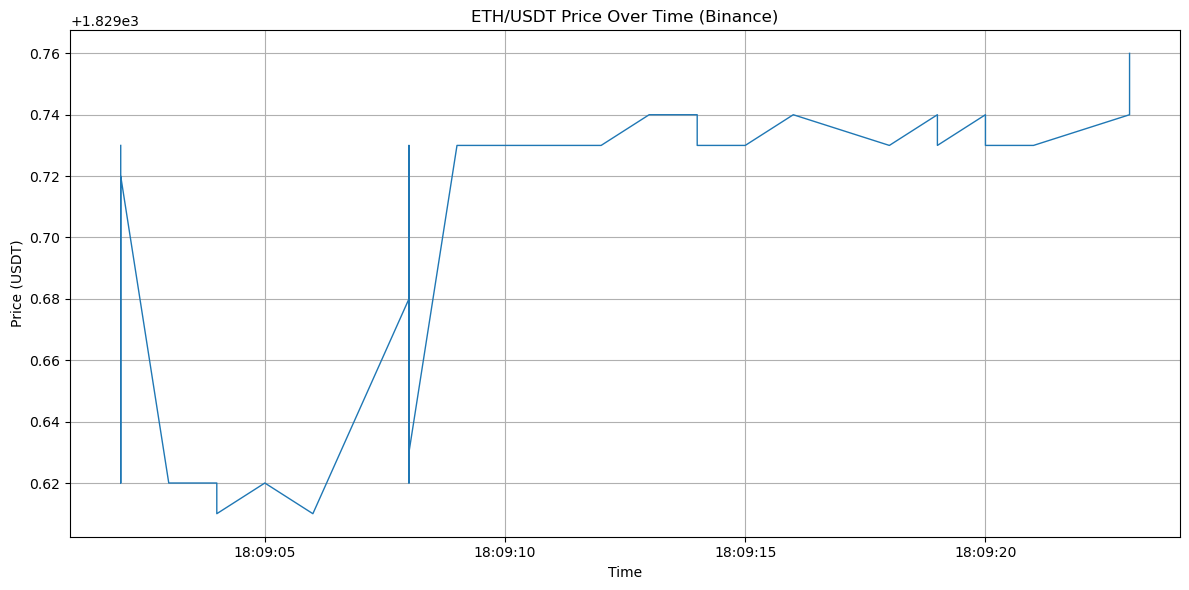

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load data
conn = sqlite3.connect('db/pricing_data.db')
df = pd.read_sql_query("SELECT * FROM price_ticks", conn)

# Step 2: Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Optional: Sort to ensure chronological order
df = df.sort_values('timestamp')

# Step 3: Plot price over time
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['price'], linewidth=1)
plt.title('ETH/USDT Price Over Time (Binance)')
plt.xlabel('Time')
plt.ylabel('Price (USDT)')
plt.grid(True)
plt.tight_layout()
plt.show()
